In [1]:
import numpy as np
import ot
import ot.plot
import matplotlib.pyplot as plt
from ot.datasets import make_1D_gauss as gauss
import sklearn.datasets as datasets
import graphlearning as gl

2023-01-31 19:41:58.351977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 19:41:58.351997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Example of OT problem w/out optimal plan

$$ \alpha \sim \text{Uni}( \{0 \} \times [0,1]),  \beta \sim \text{Uni}( \{-1, 1 \} \times [0,1])$$
Then the optimal plan is
$$ \text d \pi (x,y) = \text d (x_1 \lfloor[0,1]) \text d \delta_0(x_2) \text d \delta_{x_1}(y_1)\frac{ \text{d}\delta_{-1}(y_2) + \text{d}\delta_{1}(y_2))}{2}$$
See also exercise 2.14 from Topics in Optimal Transport

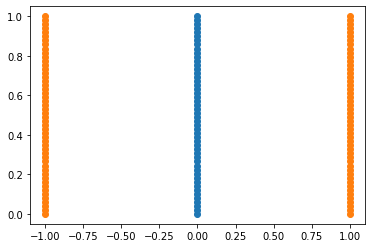

In [222]:
n = 50 # nb bins

# bin positions
x  = np.hstack( ( np.zeros((n,1)), np.linspace(0, 1, num = n).reshape(n,1) ) )
y1 = np.hstack( ( np.ones((n,1)), np.linspace(0, 1, num = n).reshape(n,1) ) )
y2 = np.hstack( ( -np.ones((n,1)), np.linspace(0, 1, num = n).reshape(n,1) ) )
y = np.vstack( (y1, y2) )
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(y[:, 0], y[:, 1])
    
a = np.array([1/n] * n)
b = np.array([1/(2*n)] * 2 * n)

# loss matrix
M = ot.dist(x.reshape((n, 2)), y.reshape((2 * n, 2)))

(50,)


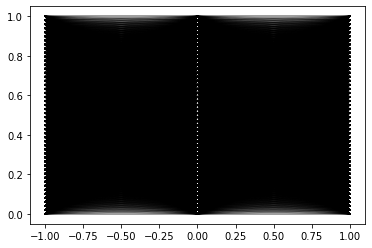

In [223]:
print(a.shape)
ot.plot.plot2D_samples_mat(x, y, M)

In [224]:
optimal_plan = ot.emd(a, b, M)

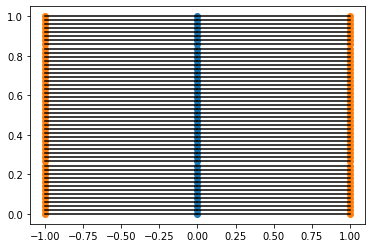

In [225]:
G = optimal_plan

mx = G.max()
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        plt.plot([x[i, 0], y[j, 0]], [x[i, 1], y[j, 1]],
                alpha = G[i, j] / mx, color = 'k')
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(y[:, 0], y[:, 1])
plt.show()

# Kantorovich potential over two moons

We generate some points from two moons and then pick some of these $a_1, \dots, a_k$ from the upper moon and some points $b_1, \dots, b_k$ from the lower moon and consider the measures $$\alpha = \frac{1}{n} \sum_1^n \delta_{a_i},  \beta = \frac{1}{n} \sum_1^n \delta_{b_i}$$ over all the generated points. Then we consider the dual OT problem:

$$ \max \{ \left<\alpha, u \right> + \left<\beta, v \right> |\ u(a_i) + v(b_j) \leq M_{ij} \forall i,j \} $$
where $M_{ij} = |x_i - y_j|$, and use $v$ as a classifier.

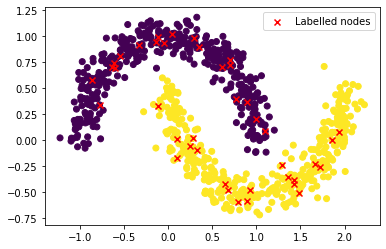

In [3]:
n = 400 # Number of samples per class
lab_n = 20 # Number of labels per class

# Generate data sets
X, labels = datasets.make_moons(n_samples = (n, n), noise = 0.1, random_state=0) # Generate point clouds and labels
train_ind = gl.trainsets.generate(labels, rate = lab_n, seed = 0) # Generate indices of "labeled" nodes
labels = 2 * labels - 1 # Labels should be -1, 1 and not 0, 1
train_labels = labels[train_ind]

plt.scatter(X[:, 0], X[:, 1], c = labels)
plt.scatter(X[train_ind, 0], X[train_ind, 1], color = 'red', marker = 'x', label = "Labelled nodes")

plt.legend()
plt.show()

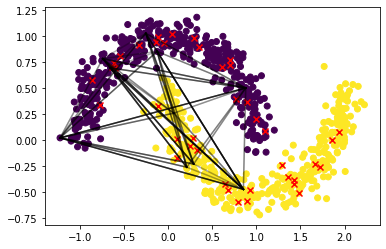

In [4]:
a_idx = train_ind[np.argwhere(labels[train_ind] == 1)].flatten()
b_idx = train_ind[np.argwhere(labels[train_ind] == -1)].flatten()

M = ot.dist(X, X, metric='euclidean')
ot.plot.plot2D_samples_mat(X[:10], X[:10], M)
plt.scatter(X[:, 0], X[:, 1], c = labels)
plt.scatter(X[train_ind, 0], X[train_ind, 1], color = 'red', marker = 'x', label = "Labelled nodes")

In [5]:
a = np.zeros(2 * n)
b = np.zeros(2 * n)

a[a_idx] += (1/lab_n) * np.ones(lab_n)
b[b_idx] += (1/lab_n) * np.ones(lab_n)

gamma, log = ot.emd(a, b, M, log=True, center_dual=True)

Text(0.5, 1.0, 'v')

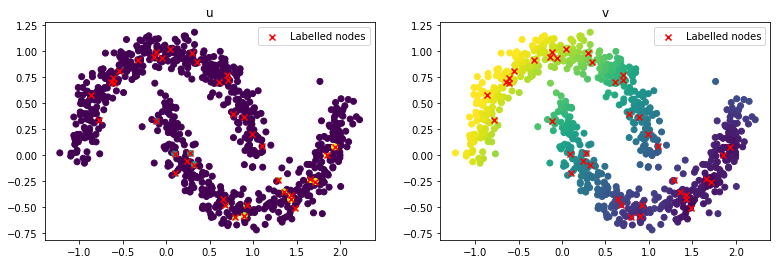

In [9]:
# print(a_idx)
# print(b_idx)
# print(a)
# print(b)
fig, ax = plt.subplots(ncols = 2, figsize = (13,4))
u = log['u']
v = log['v']

# print(u)
# print(v)

ax[0].scatter(X[:, 0], X[:, 1], c = u)
ax[0].set_title('u')
ax[0].scatter(X[train_ind, 0], X[train_ind, 1], color = 'red', marker = 'x', label = "Labelled nodes")
ax[0].legend()

ax[1].scatter(X[:, 0], X[:, 1], c = v)
ax[1].scatter(X[train_ind, 0], X[train_ind, 1], color = 'red', marker = 'x', label = "Labelled nodes")
ax[1].legend()
ax[1].set_title('v')

In [7]:
print("First potential u\n", u)
print("Second potential v\n", v)
#print(np.inner(a, u) + np.inner(b, v))
#print(log['cost'])

First potential u
 [-1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329  1.12749779 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329 -1.18292329
 -1.18292329 -1.18292329 -1.1829

Text(0.5, 1.0, 'GraphLearn')

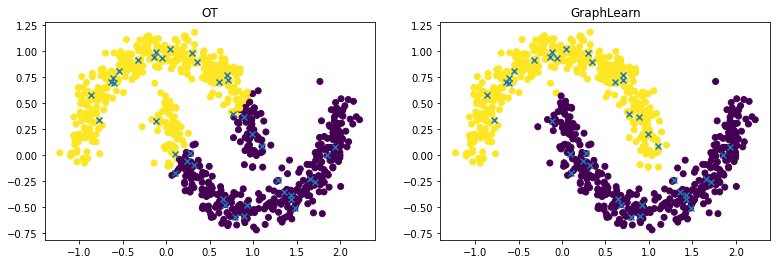

In [8]:
def predict(u):
    if u.ndim == 2:
        return np.argmax(u, axis = 1)
    else:
        return np.sign(u)

if -1 in train_labels: # Check if we already switched labelling scheme
    train_labels = 1 - (train_labels + 1) / 2 #labels should be 0,1 and not -1, 1

fig, ax = plt.subplots(ncols = 2, figsize = (13,4))


ot_pred_labels = predict(v)
ax[0].scatter(X[:,0],X[:,1], c=ot_pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[0].set_title("OT")


# GraphLearn
W = gl.weightmatrix.knn(X,10).toarray()
model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)

pred_labels = predict(u)

ax[1].scatter(X[:,0],X[:,1], c=pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[1].set_title("GraphLearn")